<a href="https://colab.research.google.com/github/gmmendez/EA2SOA/blob/master/EA3_Mendez_Gonzalo_39913544_Ejercicio2_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Introduccion**

La técnica de riego por goteo se caracteriza por ser muy eficiente en el uso del agua ya que la misma se aplica en forma de gotas por emisores llamados goteros, alimentados por una tubería plástica.
Gota a gota se conforma en el suelo o en el sustrato un bulbo húmedo cuya forma y dimensión se establece en función de las características de ese medio, de la cantidad de agua aplicada y de la frecuencia con que se aplica. Esto permite lograr una zona húmeda en concordancia con la ubicación de la mayor parte de las raíces, evitando desperdicios de agua y nutrientes.

Supongamos que se dispone de una hectárea que requiere de 7 milímetros de agua diariamente, y se dispone de una bomba eléctrica de agua que expende 4000 litros de agua por hora (1.11 litros por segundo). Según el cálculo de la dotación de riego (medida usada para calcular cuanta superficie se podría regar en función del agua disponible), la cantidad de horas que debería estar en funcionamiento dicha bomba sería:



> Dotación de riego = 1.11 litros de agua por segundo / 2.78 = 0.4 mm por hectárea por hora


> Requerimiento diario de riego / Dotación = 7 milimetros / 0.4 = 17.5

Es decir que se necesitaría que la bomba se encuentre funcionando 17.5 horas al día.

En cambio, la técnica de riego por goteo establece que se debe dividir el terreno a regar en porciones, y debido a la distribución de los emisores o goteros, la superficie efectiva de aplicación se reduce aproximadamente a la mitad de cada porción ya que habrá áreas de cultivo y espacios interlineares que no se riegan.


**Veamos entonces los cálculos que lo demuestran:**

Si se subdivide la hectárea en 10 sectores de riego y, además se reduce a la mitad el área efectiva a regar (ya que existen espacios interfilares que no se riegan) podríamos aplicar unos 7 mm de lámina en solamente una hora de riego en cada una de las secciones. Por lo tanto en aproximadamente 8 horas diarias de operación de riego se puede cubrir una hectárea de cultivo, veamos:



> 1 hectárea dividida en 10 porciones = 0.1 hectárea cada porción.



> De cada porción de 0.1 hectárea, se riega efectivamente la mitad, con lo cual: 0.1 * 0.5 = 0.05 hectáreas debo regar por cada porción.


> Para regar con 7 mm de agua una hectárea necesito 17.5 horas de funcionamiento de una bomba que expende 4000 litros por hora, con lo cuál para regar 0.05 hectáreas: 17.5 horas * 0.05 hectáreas = 0.87 horas por porción de 0.05 hectareas (500 metros cuadrados).

En el presente ejercicio, se pretende resolver estos calculos mediante la utilización de dos matrices:

1- Una de ellas representará una hectárea de cultivo dividida en N porciones en las cuales, dado que en cada porción se realizó un cultivo diferente, se va a requerir una cantidad de agua distinta en cada porción diariamente.

2- La segunda matriz representará, para cada porción, la cantidad de tiempo -expresado en minutos- que se debe mantener en funcionamiento la bomba de agua para regar los milímetros requeridos por cada porción.

Cada uno de los cálculos que involucran a la matrices se desarrollarán en hilos en dos dimensiones que nos ofrece GPU, con el objetivo de que se realicen de forma paralela, independientemente el uno del otro, y de esta manera la ejecución del ejercicio no demore una gran cantidad de tiempo.

**2. Armado de ambiente**

Para poder utilizar la capacidad de procesamiento de los CUDA Core que ofrece la plataforma Colab, previamente se debe instalar en la misma el módulo CUDA para python llamado pycuda. 
PyCUDA brinda un fácil acceso a la API de cálculo paralelo CUDA de Nvidia.

In [1]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 17.7MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621008 sha256=eb8ecb9efd52556daae5b2b5ed0fc9f980bb8c02475fa51391ec46d5ee0bae5b
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=4f6db479459f103aa5e5103449c53fbe73b3c28475a04bfc0f573f017c07fbde
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


**3. Desarrollo**

A continuación se encuentra el código desarrollado para realizar el cálculo de la cantidad de horas que debe estar en funcionamiento cada bomba de agua instalada en las distintas hectareas de cultivo.

In [ ]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: true }

cant_hectareas =   100#@param {type: "number"}
# --------------------------------------------
import pycuda.driver as cuda
import pycuda.autoinit
from   pycuda.compiler import SourceModule
from datetime import datetime
tiempo_total = datetime.now()
import numpy


# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


ltsPorHora = numpy.random.randint(2000,9000)
print("Litros por hora expendidos por la bomba: ", ltsPorHora)
n = cant_hectareas
porcion = 1/(n)

# CPU - Defino la memoria de las matrices en cpu.
mmPorSector_CPU = numpy.random.randint(1, 6, size=(n, n))
mmPorSector_CPU = mmPorSector_CPU.astype(numpy.float32())

minPorSector_CPU = numpy.zeros_like(mmPorSector_CPU)
minPorSector_CPU = minPorSector_CPU.astype(numpy.float32())

#print(mmPorSector_CPU)
#print("ltsPorHora", ltsPorHora)


# CPU - reservo la memoria GPU.
mmPorSector_GPU = cuda.mem_alloc(mmPorSector_CPU.nbytes)
minPorSector_GPU = cuda.mem_alloc(minPorSector_CPU.nbytes)

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod(mmPorSector_GPU, mmPorSector_CPU)
cuda.memcpy_htod(minPorSector_GPU, minPorSector_CPU)


#CPU - Defino la funcion kernel que ejecutará en GPU
module = SourceModule("""
__global__ void calcularMinutosRiego(int n, int ltsPorHora, float porcion, float *mmPorSector, float *minPorSector)
{
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    float dotacion;
    float segundos = 3600;
    float minutos = 60;
    float hsPorHectarea;
    float riegoEfectivo;
    float hsPorSeccion;
    float coeficiente = 2.78;

    if(idx<n && idy<n)
    {
      dotacion = (ltsPorHora / segundos) / coeficiente;
      hsPorHectarea = mmPorSector[idx+(idy*n)]/dotacion;
      riegoEfectivo = porcion * 0.5;
      hsPorSeccion = riegoEfectivo * hsPorHectarea;
	    minPorSector[idx+(idy*n)] = hsPorSeccion * minutos;
    }
}

""")

kernel = module.get_function("calcularMinutosRiego")

dim_hilo_x = 16
dim_bloque_x = numpy.int( (n+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = numpy.int( (n+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_calculo = datetime.now()

kernel( numpy.int32(n), numpy.int32(ltsPorHora),numpy.float32(porcion), mmPorSector_GPU ,minPorSector_GPU, block=( dim_hilo_x, dim_hilo_y, 1 ),grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_calculo = datetime.now() - tiempo_calculo

cuda.memcpy_dtoh(minPorSector_CPU,minPorSector_GPU)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_calculo ), "[ms]" )
print("")
print("Matriz de milimetros: ")
print(mmPorSector_CPU)
print("")
print("Matriz con tiempo: ")
print(minPorSector_CPU)

Litros por hora expendidos por la bomba:  3153
Thread: [ 16 , 19  ], Bloque : [ 7 , 6 ]
Total de Thread: [ 112 , 114  ]  =  12768
Tiempo TOTAL:  5.003 [ms]
Tiempo GPU  :  0.253 [ms]

Matriz de milimetros: 
[[1. 2. 2. ... 2. 2. 3.]
 [2. 2. 1. ... 5. 1. 5.]
 [5. 2. 4. ... 1. 4. 3.]
 ...
 [1. 2. 5. ... 5. 5. 3.]
 [4. 3. 3. ... 4. 5. 4.]
 [5. 1. 5. ... 5. 5. 2.]]

Matriz con tiempo: 
[[0.95223594 1.9044719  1.9044719  ... 1.9044719  1.9044719  2.8567076 ]
 [1.9044719  1.9044719  0.95223594 ... 4.7611794  0.95223594 4.7611794 ]
 [4.7611794  1.9044719  3.8089437  ... 0.95223594 3.8089437  2.8567076 ]
 ...
 [0.95223594 1.9044719  4.7611794  ... 4.7611794  4.7611794  2.8567076 ]
 [3.8089437  2.8567076  2.8567076  ... 3.8089437  4.7611794  3.8089437 ]
 [4.7611794  0.95223594 4.7611794  ... 4.7611794  4.7611794  1.9044719 ]]


**4. Tabla de pasos**

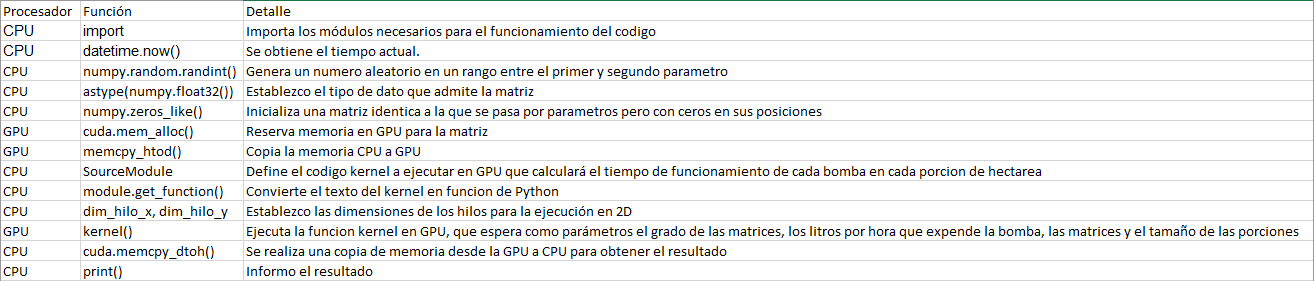

**5. Conclusiones**

*Repaso*

Tal como se puede verificar en la ejecución del ejercicio, la utilización de GPU
brinda una ventaja en el procesamiento al descargar en la misma las partes de la aplicación que requieren gran capacidad computacional para realizar cálculos en forma simultánea, mientras que el resto del código sigue ejecutándose en la CPU. La CPU está formada por varios núcleos utilizados para el procesamiento en serie, mientas que la GPU consta de grandes cantidades de núcleos más pequeños y eficientes diseñados para el rendimiento en paralelo.

El código paralelo se desarrolla en unidades separadas (kernels). El código de la CPU sigue una ejecución secuencial, mientras realiza llamadas a los kernels alojados en GPU que se ejecutan en paralelo.

Debido a lo desarrollado anteriormente, el procesamiento de matrices en hilos en dos dimensiones que nos ofrece GPU puede representar una ventaja para la resolucion de problemas como el planteado en el presente ejercicio, donde se dispone de una matriz cuadrada que representa una hectárea dividida en porciones de igual cantidad de metros cuadrados que requieren distinta cantidad de agua cada una. Cada hilo en 2D se asocia con una posicion de la matriz, y de esta forma los mismos se ejecutan en paralelo, independientemente el uno del otro. En cambio, si quisieramos ejecutar esta misma operación en forma secuencial, la cantidad de tiempo seria mayor debido a que por cada posicion de la matriz se deben realizar 5 cálculos, y para procesar la posición (0,1), primero se deberia procesar la posición (0,0), y así sucesivamente con todas las posiciones.


*Lecciones Aprendidas*

La codificacion de este ejercicio me permitió comprender de que manera se debe trabajar con hilos en dos dimensiones, y verificar a través de la ejecución del mismo cuales son sus ventajas respecto de un programa sin procesamiento paralelo. En el mismo pude llevar a la práctica el conocimiento adquirido tanto en la clase virtual como en la bibliografía detallada en la sección número 6, acerca de como se debe trabajar con matrices en el procesamiento en paralelo sobre GPU.


*Sugerencias para continuar con el ejercicio*

Una serie de funcionalidades adicionales pueden ser agregadas al ejercicio presentado para que el mismo sea más completo. Por ejemplo, se podría agregar una matriz más donde cada posición puede representar una bomba eléctrica de agua distinta, con lo cuál si el productor dispone de varias bombas de agua, podría utilizar una para cada porción de hectárea que dispone, y el ejercicio se encargaría de calcular el tiempo que cada una de las bombas debe estar en funcionamiento. Otra posible sugerencia sería que el productor (usuario) tenga la posibilidad ingresar la cantidad de agua que requiere cada porción de la hectárea a la matriz.

**6. Bibliografia**

[1] Programación en CUDA: [Sitio web](https://riubu.ubu.es/bitstream/handle/10259/3933/Programacion_en_CUDA.pdf;jsessionid=AAD15F54049E00A45B83F863126BD94E?sequence=1)

[2] Tutorial PyCUDA: [Sitio web](https://documen.tician.de/pycuda/tutorial.html)

[3] Documentacion Numpy: [Sitio web](https://numpy.org)

[4] Documentacion PyCUDA: [Sitio web](https://documen.tician.de/pycuda/index.html)

[5] INTA - Riego por goteo: [Sitio web](https://inta.gob.ar/sites/default/files/inta_disenio-proyectos-de-riego-por-goteo.pdf)